# Check the trend of COVID-19 cases around the world - JupyterLab

This Notebook demonstrates how to use [Eikon Data API](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api). and Geopandas to show number of Covid-19 cases around the world
## [STEP 1] Import related libraries

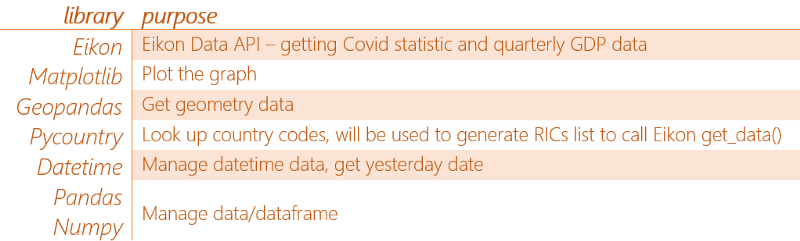

In [1]:
# import necessary libraries
import eikon as ek
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime, timedelta
import numpy as np
import pycountry

## [STEP 2] DATA GATHERING
Prepare RICs list to be used in Eikon's get_data() function, you may search for other indicators in Eikon's <b>Economic indicator chart (ECOC)</b> and modify RIC structure here based on the indicator you're interested

In [6]:
yesterday_date = (datetime.today()- timedelta(days=1)).strftime('%Y-%m-%d')

# Getting geo data from geopandas (geometry and population of each country code)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# map the country code iso alpha 3 and 2 together as we need country code iso alpha 2 to generate RICs list
mapping = {country.alpha_3: country.alpha_2 for country in pycountry.countries}

# filter only the country which is availble in geopandas
country_codes = []
gpd_country_list = world['iso_a3'].to_list()
for country_code_3 in mapping:
    if country_code_3 in gpd_country_list:
        country_codes.append(mapping[country_code_3])

# generate RICs list
rics = {'total_case': []
        , 'new_case': []
        , 'death': []}

for country_code in country_codes:
    rics['total_case'].append(f'{country_code}COVD=ECI') # case, volume
    rics['new_case'].append(f'{country_code}NCOV=ECI') # new cases, volume
    rics['death'].append(f'{country_code}DCOV=ECI') # deaths, volume

Then call Eikon Data API to get latest COVID-19 statistic

#### Fields supported by these economic indicators are
 - <b>DSPLY_NMLL:</b>	Display name of an indicator<br>
 - <b>COUNTRY:</b>	Country code<br>
 - <b>CF_DATE:</b>	Announcement date<br>
 - <b>ECON_PRIOR:</b>	Prior value<br>
 - <b>ECON_AC:</b>	Actual value<br>

I'm going to use ECON_PRIOR instead of ECON_ACT as I'd like to use data of the day before, which is the stable one.

In [7]:
# first, get data of covid cases from Eikon
ek.set_app_key('#### PUT YOUR VALID APP KEY HERE ####')

# mapping between the column name and existing description in the response dataframe
case_to_get = {'total_case': 'NCOV19 Tot Cases RTR',
               'new_case': 'NCOV19 New Cases RTR',
               'death': 'NCOV19 Deaths RTR'}

fields = ['DSPLY_NMLL',  # Display Name
          'COUNTRY',    # Country code
          'CF_DATE',  # Announcement Date
          'ECON_PRIOR'     # Prior value # let's use data of the day before to get the complete one
          ]

# COVID-19 statistic RICs are now in rics list
for ric in rics:
    print(f'number of RIC types in {ric} rics list: {len(rics[ric])}')

# get COVID-19 statistic from Eikon Data API
eikon_df = {}
err = {}
for ric_type in rics:
    eikon_df[ric_type], err[ric_type] = ek.get_data(rics[ric_type], fields)

number of RIC types in total_case rics list: 172
number of RIC types in new_case rics list: 172
number of RIC types in death rics list: 172


## [STEP 3] DATA PREPARATION
Format Eikon’s response dataframes to be ready for the visualization

In [8]:
for df in eikon_df:    
    # Rename dataframe column names
    eikon_df[df].rename(columns={'DSPLY_NMLL': 'display_name',
                             'COUNTRY': 'iso_a3',
                             'CF_DATE': 'announcement_date',
                             'ECON_PRIOR': 'value'
                             }, inplace=True)
    
    # as select prior value, so let's update announcement date to the day before    
    eikon_df[df]['announcement_date'] = eikon_df[df]['announcement_date'].apply(
        lambda x: x if pd.isnull(x) else datetime.strptime(x, '%Y-%m-%d') - timedelta(days=1))

    # check column names and updated date
    display(eikon_df[df].head())

,Instrument,display_name,iso_a3,announcement_date,value
0,AFCOVD=ECI,COVID19 Tot Cases WHO,AFG,2021-09-20 00:00:00,154585
1,AOCOVD=ECI,COVID19 Tot Cases WHO,AGO,2021-09-20 00:00:00,52423
2,ALCOVD=ECI,COVID19 Tot Cases WHO,ALB,2021-09-20 00:00:00,162953
3,AECOVD=ECI,COVID19 Tot Cases WHO,ARE,2021-09-20 00:00:00,732690
4,ARCOVD=ECI,COVID19 Tot Cases WHO,ARG,2021-09-20 00:00:00,5238610


,Instrument,display_name,iso_a3,announcement_date,value
0,AFNCOV=ECI,NCOV19 New Cases RTR,AFG,2021-09-20 00:00:00,225
1,AONCOV=ECI,NCOV19 New Cases RTR,AGO,2021-09-20 00:00:00,221
2,ALNCOV=ECI,NCOV19 New Cases RTR,ALB,2021-09-20 00:00:00,451
3,AENCOV=ECI,NCOV19 New Cases RTR,ARE,2021-09-20 00:00:00,313
4,ARNCOV=ECI,NCOV19 New Cases RTR,ARG,2021-09-20 00:00:00,2162


,Instrument,display_name,iso_a3,announcement_date,value
0,AFDCOV=ECI,NCOV19 Deaths RTR,AFG,2021-09-20 00:00:00,7192
1,AODCOV=ECI,NCOV19 Deaths RTR,AGO,2021-09-20 00:00:00,1409
2,ALDCOV=ECI,NCOV19 Deaths RTR,ALB,2021-09-20 00:00:00,2587
3,AEDCOV=ECI,NCOV19 Deaths RTR,ARE,2021-09-20 00:00:00,2077
4,ARDCOV=ECI,NCOV19 Deaths RTR,ARG,2021-09-20 00:00:00,114519


Then, rearrange the dataframe to be suitable for the visualization

In [9]:
# update column name to represent each case type and drop unused columns
for df in eikon_df:    
    eikon_df[df].rename(columns={'value': df}, inplace=True)
    eikon_df[df] = eikon_df[df].drop(columns=['display_name', 'Instrument', 'announcement_date'])

## [STEP 4] Merge the data from Eikon and geometry data together
Merge Covid data from Eikon and geology data together and calculate percentage of each Covid case per population

In [10]:
# check geometry data
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [11]:
# merge geo and COVID-19 data together
for df in eikon_df:
    world = pd.merge(world, eikon_df[df], on='iso_a3', how='left')
    #print(df + ' ' + str(len(world)))
#display(world.head())

# set columns' value type to int64(numpy) from Int64(pandas) (to make it supported on plotting graph step)
for case in case_to_get:
    world[case] = pd.to_numeric(world[case], errors='coerce').fillna(0).astype('int64')

In [12]:
# calculate percentage of each case per population
def cal_case_pct_per_prop(df):
    for case in case_to_get:
        df['pct_'+case] = df[case]/df['pop_est']*100
        
    # replace 0 with NA to seperate from non-zero value in the map
    columns = ['pct_total_case', 'pct_new_case', 'pct_death']
    for col in columns:
        world.loc[world[col] == 0, col] = np.nan

cal_case_pct_per_prop(world)
    
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,total_case,new_case,death,pct_total_case,pct_new_case,pct_death
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",49959,121,575,5.424795,0.013139,0.062436
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",1367,0,50,0.002534,NaN,0.000093
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0,0,0,NaN,NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1569186,3852,27434,4.404896,0.010813,0.077011
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",41831507,208016,677791,12.807166,0.063686,0.207513


## [STEP 5] DATA VISUALIZATION
Plot world graph<br>
- To reduce the bias, the country with no data is colored as light grey color with black hatch

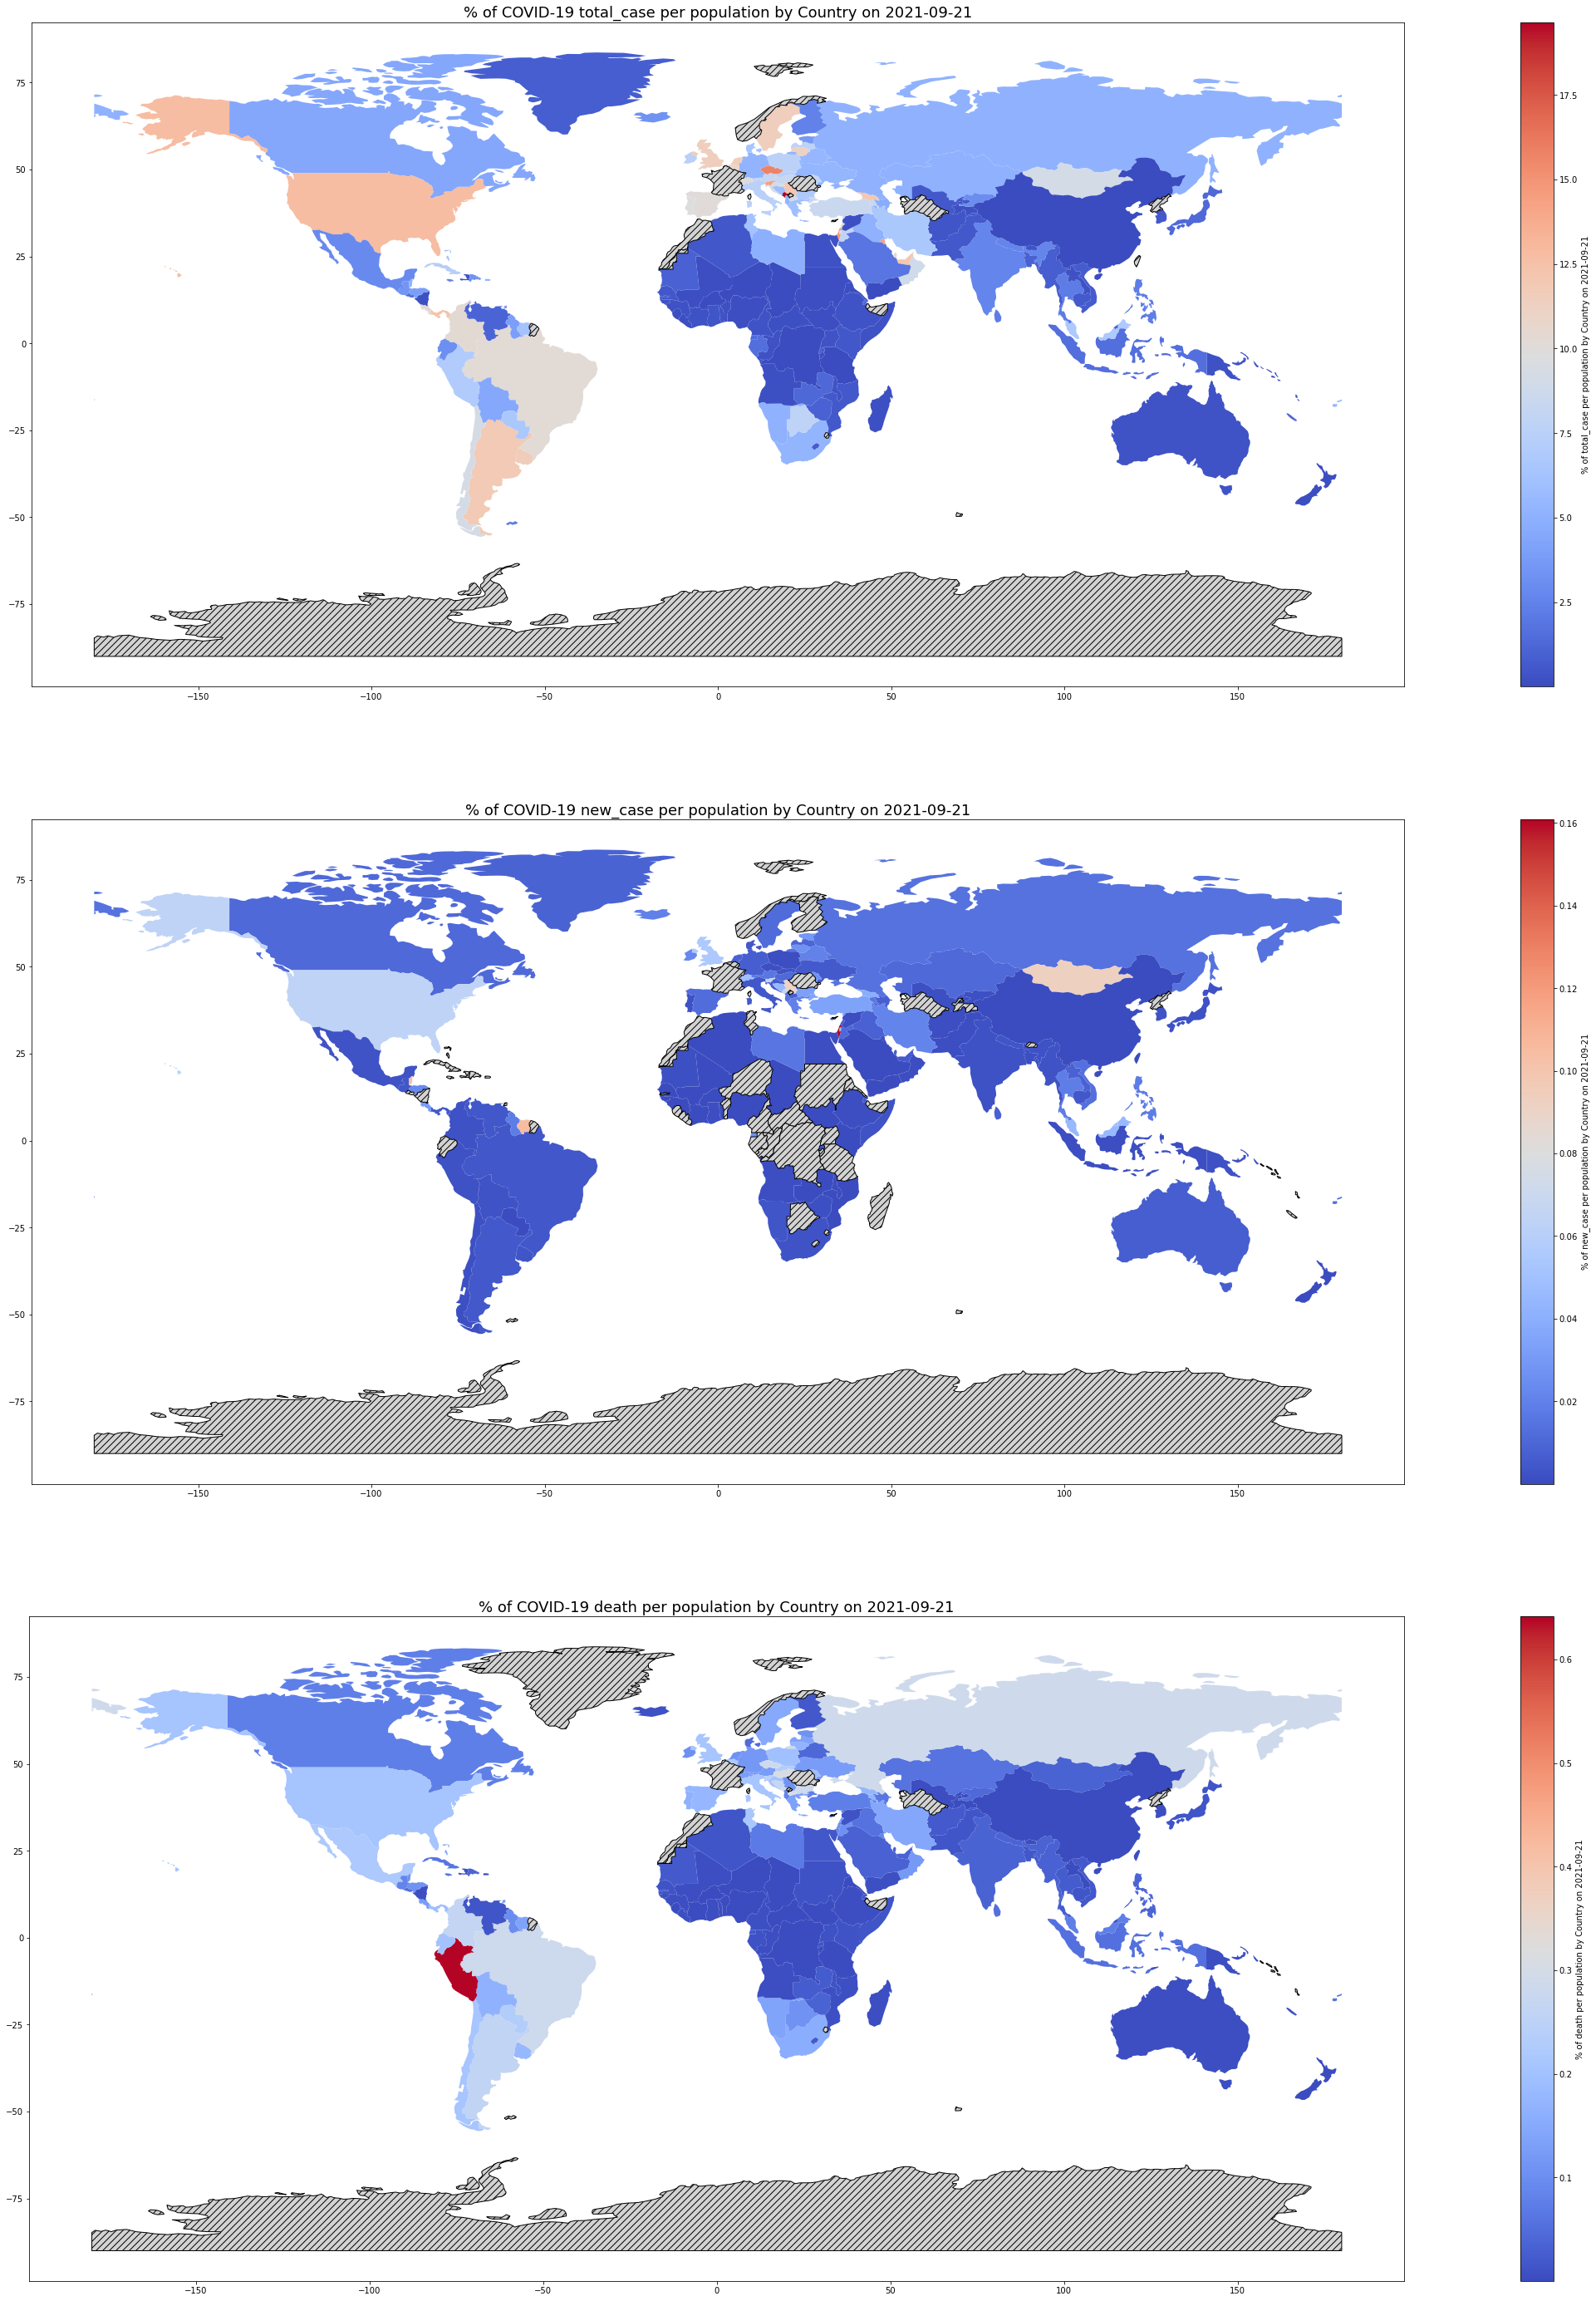

In [13]:
def plot_world_covid(df):
    axs = [ax1, ax2, ax3]
    count = 0
    for case in case_to_get:
        axs[count].set_title(f"% of COVID-19 {case} per population by Country on {yesterday_date}", fontsize=18)
        df.plot(column='pct_' + case, ax=axs[count], legend=True, cmap='coolwarm',
                legend_kwds={'label': f"% of {case} per population by Country on {yesterday_date}",
                             'orientation': "vertical"},
                missing_kwds={
                    "color": "lightgrey",
                    "edgecolor": "black",
                    "hatch": "///",
                    "label": "Missing values"}
               )
        count += 1

# plot graph
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(50, 50))

plot_world_covid(world)

plt.show()

## Conclusion
Eikon Data API which not only can provide the financial data, but it can also provide the data of Economic Indicators such as, Coronavirus (COVID-19) new cases/ total cases/ deaths data of each country, then plotting these data into the world map helps me to see the trend of these data around the world in a glance. Do you have any data you're curious to know about? If so, please feel free to check Eikon Data API which have been providing a lot of useful data of each country/company around the world.

## Reference
#### Eikon
 - [About Eikon Data API](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api)

#### Geopandas
 - [Geopandas: making maps and plots](https://geopandas.org/docs/user_guide/mapping.html)
 - [to see color map (cmap)](https://matplotlib.org/2.0.2/users/colormaps.html)

## Thanks, I hope you enjoy this! :)